In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer

In [3]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [5]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [6]:
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [7]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
import timeit
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [10]:
# Создание пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: tokenizer.encode(x, add_special_tokens=True))),
    ('knn', KNeighborsClassifier(n_neighbors=3))  # Можно изменить количество соседей
])

# Обучение пайплайна
pipeline.fit(train['text'], train['intent'])



start_test = timeit.default_timer()
# Прогноз на тестовом наборе
predictions = pipeline.predict(test['text'])
end_test = timeit.default_timer()
# Общее количество предсказанных ответов
num_predictions = len(predictions)
# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

print(balanced_accuracy_score(test['intent'], predictions))
print(precision_recall_fscore_support(test['intent'], predictions, average = 'weighted'))


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time for testing: 1.0891 seconds
Average time per response: 0.001111 seconds
0.5280785704866306
(0.8932856814002091, 0.9030612244897959, 0.8952928277764148, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


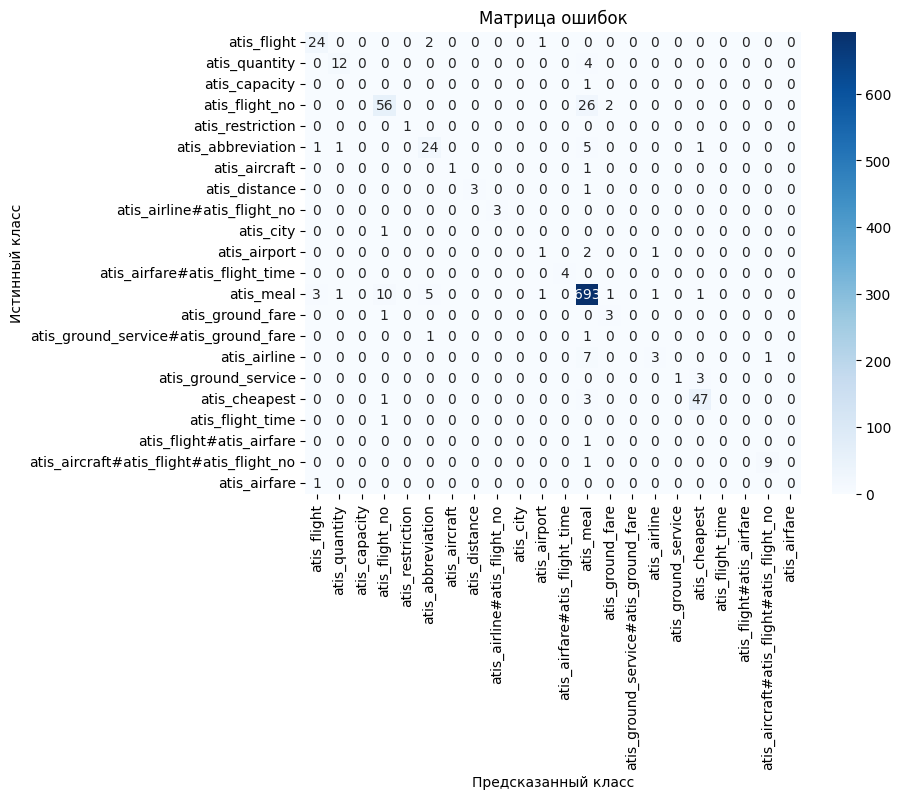

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Построение матрицы ошибок
conf_matrix = confusion_matrix(test['intent'], predictions)

# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(test['intent']), yticklabels=set(test['intent']))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

M-USE

In [12]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

In [13]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

In [15]:
# Use KNeighborsClassifier for classification
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(train_embeddings, train['intent'])

start_test = timeit.default_timer()
# Make predictions
predictions = knn.predict(test_embeddings)
end_test = timeit.default_timer()

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

# Evaluate the model
print(precision_recall_fscore_support(test['intent'], predictions, average='weighted'))
print(balanced_accuracy_score(test['intent'], predictions))

Time for testing: 0.1420 seconds
Average time per response: 0.000145 seconds
(0.8590134465460133, 0.8693877551020408, 0.8560633749190246, None)
0.4282681401417958


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mini-LM

In [16]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [17]:
# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

In [18]:
# Use KNeighborsClassifier for classification
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(train_embeddings, train['intent'])

start_test = timeit.default_timer()
# Make predictions
predictions = knn.predict(test_embeddings)
end_test = timeit.default_timer()

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

# Evaluate the model
print(precision_recall_fscore_support(test['intent'], predictions, average='weighted'))
print(balanced_accuracy_score(test['intent'], predictions))

Time for testing: 0.1009 seconds
Average time per response: 0.000103 seconds
(0.8781692401243261, 0.8918367346938776, 0.8796542014236738, None)
0.4152426157182789


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
